In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import pydot
import graphviz
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

tfku= tf.keras.utils
tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 
STEPS_PER_EPOCH = 200
ID = 28

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             589
      1             484
1     0             555
      1             449
2     0             641
      1             552
3     0             343
      1             282
4     0             456
      1             382

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in ids: 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
def slice_random(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

In [9]:
def fix_type(x, y):

    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [10]:
def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(slice_random)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [11]:
def get_train_and_val_for_fold(folded_datasets, fold):
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [12]:
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

In [13]:
class Autoencoder_subclass(tfk.Model):
    def __init__(self):
        super(Autoencoder_subclass, self).__init__()
        self.encoder = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
        ])
        
        self.decoder = tf.keras.Sequential([
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.GlobalAveragePooling1D(),
            tfkl.Dense(1, activation='sigmoid'),
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def build_graph(self, BLOCK_SHAPE):
        x = tfkl.Input(shape=BLOCK_SHAPE)
        return tfk.Model(inputs=[x], outputs=self.call(x))
    

In [14]:
def Autoencoder():
    model = tfk.Sequential([
        tfk.Input(shape=BLOCK_SHAPE),
        #encoder
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(rate=0.5),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(rate=0.5),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(rate=0.5),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(rate=0.5),
        #decoder
        tfkl.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.GlobalAveragePooling1D(),
        tfkl.Dense(1, activation='sigmoid'),
    ])
    
    return model

In [15]:
class Conv1D_subclass(tfk.Model):
    def __init__(self):
        super(Conv1D_subclass, self).__init__()
        self.conv1D_model = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.GlobalAveragePooling1D(),
            tfkl.Dense(1, activation='sigmoid'),
        ])
            
    def call(self, x):
        conv1D = self.conv1D_model(x)
        return conv1D
    
    def build_graph(self, BLOCK_SHAPE):
        x = tfkl.Input(shape=BLOCK_SHAPE)
        return tfk.Model(inputs=[x], outputs=self.call(x))

In [16]:
def Conv1D():
    model = tfk.Sequential([
        tfk.Input(shape=BLOCK_SHAPE),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.GlobalAveragePooling1D(),
        tfkl.Dense(1, activation='sigmoid'),
    ])
    
    return model

In [17]:
cnn1D_encoder_result = {}

for i in range(NFOLD-1):
    autoencoder = Autoencoder()
    tfku.plot_model(
        autoencoder,
        to_file='autoencoder_model{i}.png'.format(i=i), dpi=96,
        show_shapes=True, show_layer_names=True,
        expand_nested=False
    )
    autoencoder.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', 
                                   tfk.metrics.RootMeanSquaredError(),
                                  ],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = autoencoder.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnn1D_encoder_result[i] = result.history

pd.DataFrame(cnn1D_encoder_result)

Epoch 1/30
200/200 [==============================] - 22s 12ms/step - loss: 0.2410 - accuracy: 0.9995 - root_mean_squared_error: 0.4910 - val_loss: 0.2503 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5003
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2356 - accuracy: 1.0000 - root_mean_squared_error: 0.4854 - val_loss: 0.2505 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5005
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2273 - accuracy: 1.0000 - root_mean_squared_error: 0.4767 - val_loss: 0.2509 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5009
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2139 - accuracy: 1.0000 - root_mean_squared_error: 0.4625 - val_loss: 0.2521 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5021
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 0.1933 - accuracy: 1.0000 - root_mean_squared_error: 0.4397 - va

200/200 [==============================] - 2s 10ms/step - loss: 0.1156 - accuracy: 1.0000 - root_mean_squared_error: 0.3401 - val_loss: 0.2783 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5275
Epoch 9/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0759 - accuracy: 1.0000 - root_mean_squared_error: 0.2755 - val_loss: 0.3033 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5507
Epoch 10/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0464 - accuracy: 1.0000 - root_mean_squared_error: 0.2155 - val_loss: 0.3302 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5746
Epoch 11/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0308 - accuracy: 1.0000 - root_mean_squared_error: 0.1754 - val_loss: 0.3546 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5955
Epoch 12/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0223 - accuracy: 1.0000 - root_mean_squared_error: 0.1492 - val_loss: 0

200/200 [==============================] - 2s 11ms/step - loss: 0.0141 - accuracy: 1.0000 - root_mean_squared_error: 0.1187 - val_loss: 0.3937 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6275
Epoch 16/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0139 - accuracy: 1.0000 - root_mean_squared_error: 0.1177 - val_loss: 0.4088 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6394
Epoch 17/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0128 - accuracy: 1.0000 - root_mean_squared_error: 0.1131 - val_loss: 0.4247 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6517
Epoch 18/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0120 - accuracy: 1.0000 - root_mean_squared_error: 0.1093 - val_loss: 0.4279 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6542ss: 0.0128 - accuracy: 1.0000 - roo
Epoch 19/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0115 - accuracy: 1.0000 - root_mean

Epoch 23/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0096 - accuracy: 1.0000 - root_mean_squared_error: 0.0980 - val_loss: 0.4739 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6884
Epoch 24/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0083 - accuracy: 1.0000 - root_mean_squared_error: 0.0912 - val_loss: 0.4797 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6926
Epoch 25/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0091 - accuracy: 1.0000 - root_mean_squared_error: 0.0953 - val_loss: 0.4847 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6962
Epoch 26/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0094 - accuracy: 1.0000 - root_mean_squared_error: 0.0968 - val_loss: 0.4806 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6932
Epoch 27/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0096 - accuracy: 1.0000 - root_mean_squared_error: 0.0982 - val

,0,1,2,3
loss,"[0.24104200303554535, 0.23559685051441193, 0.2...","[0.2478448897600174, 0.24439606070518494, 0.23...","[0.25072404742240906, 0.24908898770809174, 0.2...","[0.2525727152824402, 0.2497033327817917, 0.246..."
accuracy,"[0.9995312690734863, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9996874928474426, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.12937499582767487, 0.9642187356948853, 1.0,...","[0.04125000163912773, 0.6228125095367432, 1.0,..."
root_mean_squared_error,"[0.4909602701663971, 0.48538321256637573, 0.47...","[0.4978402256965637, 0.49436429142951965, 0.48...","[0.5007234811782837, 0.4990881681442261, 0.497...","[0.5025660991668701, 0.49970322847366333, 0.49..."
val_loss,"[0.2502865791320801, 0.2505110204219818, 0.250...","[0.2501598596572876, 0.25036588311195374, 0.25...","[0.250021755695343, 0.2500685155391693, 0.2501...","[0.24997937679290771, 0.25005921721458435, 0.2..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.4526209533214569, 0.4526209533214569, 0.452...","[0.46621620655059814, 0.46621620655059814, 0.4...","[0.5542762875556946, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.5002864599227905, 0.5005107522010803, 0.500...","[0.5001598000526428, 0.5003657341003418, 0.500...","[0.500021755695343, 0.5000684857368469, 0.5001...","[0.4999793767929077, 0.500059187412262, 0.5001..."


In [18]:
cnn1D_encoder_subclass_result = {}

for i in range(NFOLD-1):
    autoencoder = Autoencoder_subclass()
    tfku.plot_model(
        autoencoder.build_graph(BLOCK_SHAPE),
        to_file='autoencoder_subclass_model{i}.png'.format(i=i), dpi=96,
        show_shapes=True, show_layer_names=True,
        expand_nested=False
    )
    autoencoder.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', 
                                   tfk.metrics.RootMeanSquaredError(),
                                  ],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = autoencoder.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnn1D_encoder_subclass_result[i] = result.history

pd.DataFrame(cnn1D_encoder_subclass_result)

Epoch 1/30
200/200 [==============================] - 3s 11ms/step - loss: 0.2472 - accuracy: 0.9997 - root_mean_squared_error: 0.4972 - val_loss: 0.2501 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5001
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2438 - accuracy: 1.0000 - root_mean_squared_error: 0.4937 - val_loss: 0.2502 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5002
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2384 - accuracy: 1.0000 - root_mean_squared_error: 0.4883 - val_loss: 0.2505 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5005
Epoch 4/30
200/200 [==============================] - 2s 11ms/step - loss: 0.2297 - accuracy: 1.0000 - root_mean_squared_error: 0.4792 - val_loss: 0.2509 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5009
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2155 - accuracy: 1.0000 - root_mean_squared_error: 0.4642 - val

200/200 [==============================] - 2s 10ms/step - loss: 0.1890 - accuracy: 1.0000 - root_mean_squared_error: 0.4347 - val_loss: 0.2559 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.50581940 - accuracy: 1.0000 - root_mean_s
Epoch 9/30
200/200 [==============================] - 2s 10ms/step - loss: 0.1533 - accuracy: 1.0000 - root_mean_squared_error: 0.3915 - val_loss: 0.2624 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5123
Epoch 10/30
200/200 [==============================] - 2s 10ms/step - loss: 0.1099 - accuracy: 1.0000 - root_mean_squared_error: 0.3315 - val_loss: 0.2753 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5247
Epoch 11/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0715 - accuracy: 1.0000 - root_mean_squared_error: 0.2674 - val_loss: 0.3008 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5485
Epoch 12/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0438 - accuracy: 1.0000 - root_mea

200/200 [==============================] - 2s 10ms/step - loss: 0.0148 - accuracy: 1.0000 - root_mean_squared_error: 0.1216 - val_loss: 0.4202 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6482
Epoch 16/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0133 - accuracy: 1.0000 - root_mean_squared_error: 0.1154 - val_loss: 0.4347 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6593
Epoch 17/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0124 - accuracy: 1.0000 - root_mean_squared_error: 0.1112 - val_loss: 0.4473 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6688
Epoch 18/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0119 - accuracy: 1.0000 - root_mean_squared_error: 0.1090 - val_loss: 0.4546 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6742
Epoch 19/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0112 - accuracy: 1.0000 - root_mean_squared_error: 0.1057 - val_loss: 

200/200 [==============================] - 2s 9ms/step - loss: 0.0087 - accuracy: 1.0000 - root_mean_squared_error: 0.0932 - val_loss: 0.4785 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6917
Epoch 23/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0085 - accuracy: 1.0000 - root_mean_squared_error: 0.0923 - val_loss: 0.4840 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6957
Epoch 24/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0098 - accuracy: 1.0000 - root_mean_squared_error: 0.0990 - val_loss: 0.4885 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6989
Epoch 25/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0086 - accuracy: 1.0000 - root_mean_squared_error: 0.0928 - val_loss: 0.4915 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7011
Epoch 26/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0965 - val_loss: 0.497

,0,1,2,3
loss,"[0.24719394743442535, 0.24376796185970306, 0.2...","[0.2509911358356476, 0.24919244647026062, 0.24...","[0.25115156173706055, 0.24905799329280853, 0.2...","[0.2458348125219345, 0.24179813265800476, 0.23..."
accuracy,"[0.9996874928474426, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.08874999731779099, 0.9048437476158142, 1.0,...","[0.09093750268220901, 0.8981249928474426, 1.0,...","[0.9996874928474426, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
root_mean_squared_error,"[0.4971860349178314, 0.4937286376953125, 0.488...","[0.5009901523590088, 0.4991917908191681, 0.497...","[0.5011501908302307, 0.4990571141242981, 0.496...","[0.4958173334598541, 0.491729736328125, 0.4854..."
val_loss,"[0.2501136362552643, 0.2502383887767792, 0.250...","[0.2500210106372833, 0.25007882714271545, 0.25...","[0.2500201463699341, 0.2500799000263214, 0.250...","[0.25018489360809326, 0.2503378093242645, 0.25..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.4526209533214569, 0.4526209533214569, 0.452...","[0.46621620655059814, 0.46621620655059814, 0.4...","[0.4638157784938812, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.5001136064529419, 0.500238299369812, 0.5004...","[0.5000209808349609, 0.5000787973403931, 0.500...","[0.5000201463699341, 0.500079870223999, 0.5001...","[0.5001848340034485, 0.5003376603126526, 0.500..."


In [19]:
cnnv1D_result = {}

for i in range(NFOLD-1):
    conv1D = Conv1D()
    tfku.plot_model(
        conv1D,
        to_file='conv1D_model{i}.png'.format(i=i), dpi=96,
        show_shapes=True, show_layer_names=True,
        expand_nested=False
    )
    conv1D.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = conv1D.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnnv1D_result[i] = result.history

pd.DataFrame(cnnv1D_result)

Epoch 1/30
200/200 [==============================] - 2s 8ms/step - loss: 0.2591 - accuracy: 0.0913 - root_mean_squared_error: 0.5090 - val_loss: 0.2500 - val_accuracy: 0.5028 - val_root_mean_squared_error: 0.5000
Epoch 2/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2388 - accuracy: 0.9592 - root_mean_squared_error: 0.4887 - val_loss: 0.2525 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5025
Epoch 3/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2141 - accuracy: 1.0000 - root_mean_squared_error: 0.4628 - val_loss: 0.2582 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5082
Epoch 4/30
200/200 [==============================] - 2s 8ms/step - loss: 0.1876 - accuracy: 1.0000 - root_mean_squared_error: 0.4331 - val_loss: 0.2652 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5149
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1604 - accuracy: 1.0000 - root_mean_squared_error: 0.4005 - val_loss

200/200 [==============================] - 1s 7ms/step - loss: 0.0274 - accuracy: 1.0000 - root_mean_squared_error: 0.1655 - val_loss: 0.4241 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6512
Epoch 10/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0219 - accuracy: 1.0000 - root_mean_squared_error: 0.1479 - val_loss: 0.4384 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6621
Epoch 11/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0192 - accuracy: 1.0000 - root_mean_squared_error: 0.1384 - val_loss: 0.4549 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6744
Epoch 12/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0165 - accuracy: 1.0000 - root_mean_squared_error: 0.1283 - val_loss: 0.4671 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6835
Epoch 13/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0139 - accuracy: 1.0000 - root_mean_squared_error: 0.1177 - val_loss: 0.476

200/200 [==============================] - 1s 7ms/step - loss: 0.0114 - accuracy: 1.0000 - root_mean_squared_error: 0.1068 - val_loss: 0.4878 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6984
Epoch 18/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0101 - accuracy: 1.0000 - root_mean_squared_error: 0.1004 - val_loss: 0.4929 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7021
Epoch 19/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0108 - accuracy: 1.0000 - root_mean_squared_error: 0.1039 - val_loss: 0.5009 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7078
Epoch 20/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0103 - accuracy: 1.0000 - root_mean_squared_error: 0.1016 - val_loss: 0.5010 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7078
Epoch 21/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0097 - accuracy: 1.0000 - root_mean_squared_error: 0.0987 - val_loss: 0.505

200/200 [==============================] - 1s 6ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0967 - val_loss: 0.5156 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7180
Epoch 26/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0967 - val_loss: 0.5200 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7211
Epoch 27/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0084 - accuracy: 1.0000 - root_mean_squared_error: 0.0914 - val_loss: 0.5173 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7192
Epoch 28/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0079 - accuracy: 1.0000 - root_mean_squared_error: 0.0886 - val_loss: 0.5165 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7187
Epoch 29/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0088 - accuracy: 1.0000 - root_mean_squared_error: 0.0937 - val_loss: 0.523

,0,1,2,3
loss,"[0.259126752614975, 0.23881490528583527, 0.214...","[0.19967474043369293, 0.16972453892230988, 0.1...","[0.1946701854467392, 0.1693391352891922, 0.142...","[0.186809241771698, 0.16107434034347534, 0.132..."
accuracy,"[0.09125000238418579, 0.9592187404632568, 1.0,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9996874928474426, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9996874928474426, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
root_mean_squared_error,"[0.5090449452400208, 0.4886869192123413, 0.462...","[0.4468497931957245, 0.4119763970375061, 0.373...","[0.4412144422531128, 0.41150838136672974, 0.37...","[0.4322143495082855, 0.40134066343307495, 0.36..."
val_loss,"[0.24998219311237335, 0.25251853466033936, 0.2...","[0.26267871260643005, 0.27190208435058594, 0.2...","[0.26087984442710876, 0.26941001415252686, 0.2...","[0.26408353447914124, 0.27453550696372986, 0.2..."
val_accuracy,"[0.5028409361839294, 0.4583333432674408, 0.458...","[0.4526209533214569, 0.4526209533214569, 0.452...","[0.46621620655059814, 0.46621620655059814, 0.4...","[0.4638157784938812, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.49998217821121216, 0.5025122165679932, 0.50...","[0.5125219225883484, 0.5214422941207886, 0.536...","[0.5107640027999878, 0.519047200679779, 0.5290...","[0.5138905644416809, 0.5239613652229309, 0.538..."


In [20]:
cnnv1D_subclass_result = {}

for i in range(NFOLD-1):
    conv1D = Conv1D_subclass()
    tfku.plot_model(
        conv1D.build_graph(BLOCK_SHAPE),
        to_file='conv1D_model_subclass{i}.png'.format(i=i), dpi=96,
        show_shapes=True, show_layer_names=True,
        expand_nested=False
    )
    conv1D.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = conv1D.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnnv1D_subclass_result[i] = result.history

pd.DataFrame(cnnv1D_subclass_result)

Epoch 1/30
200/200 [==============================] - 2s 8ms/step - loss: 0.2215 - accuracy: 0.9992 - root_mean_squared_error: 0.4706 - val_loss: 0.2555 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5055
Epoch 2/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2009 - accuracy: 0.9998 - root_mean_squared_error: 0.4482 - val_loss: 0.2603 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5102
Epoch 3/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1787 - accuracy: 1.0000 - root_mean_squared_error: 0.4228 - val_loss: 0.2672 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5169
Epoch 4/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1534 - accuracy: 1.0000 - root_mean_squared_error: 0.3916 - val_loss: 0.2769 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5262
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1275 - accuracy: 1.0000 - root_mean_squared_error: 0.3570 - val_loss

200/200 [==============================] - 1s 7ms/step - loss: 0.0401 - accuracy: 1.0000 - root_mean_squared_error: 0.2002 - val_loss: 0.3966 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6298
Epoch 10/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0296 - accuracy: 1.0000 - root_mean_squared_error: 0.1722 - val_loss: 0.4195 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6477
Epoch 11/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0245 - accuracy: 1.0000 - root_mean_squared_error: 0.1564 - val_loss: 0.4340 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6588
Epoch 12/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0211 - accuracy: 1.0000 - root_mean_squared_error: 0.1452 - val_loss: 0.4522 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6725
Epoch 13/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0179 - accuracy: 1.0000 - root_mean_squared_error: 0.1338 - val_loss: 0.461

200/200 [==============================] - 2s 8ms/step - loss: 0.0133 - accuracy: 1.0000 - root_mean_squared_error: 0.1154 - val_loss: 0.4735 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6881
Epoch 18/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0116 - accuracy: 1.0000 - root_mean_squared_error: 0.1079 - val_loss: 0.4807 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6933
Epoch 19/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0112 - accuracy: 1.0000 - root_mean_squared_error: 0.1060 - val_loss: 0.4872 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6980
Epoch 20/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0123 - accuracy: 1.0000 - root_mean_squared_error: 0.1109 - val_loss: 0.4915 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7011
Epoch 21/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0108 - accuracy: 1.0000 - root_mean_squared_error: 0.1041 - val_loss: 0.491

200/200 [==============================] - 1s 6ms/step - loss: 0.0097 - accuracy: 1.0000 - root_mean_squared_error: 0.0984 - val_loss: 0.5061 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7114
Epoch 26/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0963 - val_loss: 0.5125 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7159
Epoch 27/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0096 - accuracy: 1.0000 - root_mean_squared_error: 0.0979 - val_loss: 0.5184 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7200
Epoch 28/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0962 - val_loss: 0.5185 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7200
Epoch 29/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0965 - val_loss: 0.515

,0,1,2,3
loss,"[0.2214515656232834, 0.20088215172290802, 0.17...","[0.2613867521286011, 0.23015867173671722, 0.19...","[0.23235124349594116, 0.2095300257205963, 0.18...","[0.1610197126865387, 0.13306786119937897, 0.10..."
accuracy,"[0.999218761920929, 0.9998437762260437, 1.0, 1...","[0.18406249582767487, 0.9810937643051147, 0.99...","[0.9982812404632568, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9993749856948853, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
root_mean_squared_error,"[0.4705863893032074, 0.4481987953186035, 0.422...","[0.5112599730491638, 0.47974854707717896, 0.44...","[0.4820282459259033, 0.4577444791793823, 0.424...","[0.40127262473106384, 0.3647846579551697, 0.32..."
val_loss,"[0.2555149793624878, 0.26028385758399963, 0.26...","[0.25074511766433716, 0.25532665848731995, 0.2...","[0.25284847617149353, 0.2583189904689789, 0.26...","[0.27311190962791443, 0.2886418402194977, 0.30..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.44758063554763794, 0.4506048262119293, 0.45...","[0.46621620655059814, 0.46621620655059814, 0.4...","[0.4638157784938812, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.5054848790168762, 0.5101802349090576, 0.516...","[0.5007445216178894, 0.5052985548973083, 0.513...","[0.5028403997421265, 0.508250892162323, 0.5163...","[0.5226011276245117, 0.5372539758682251, 0.553..."


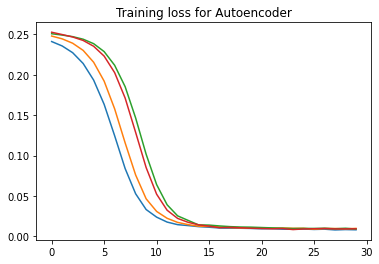

In [21]:
for i in range(NFOLD-1):
    loss = cnn1D_encoder_result[i]['loss']
    plt.plot(loss)
    plt.title('Training loss for Autoencoder')

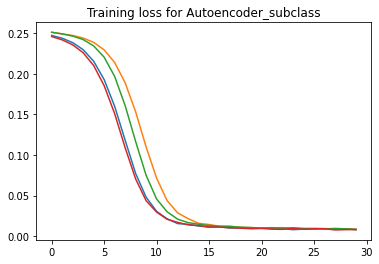

In [22]:
for i in range(NFOLD-1):
    loss = cnn1D_encoder_subclass_result[i]['loss']
    plt.plot(loss)
    plt.title('Training loss for Autoencoder_subclass')

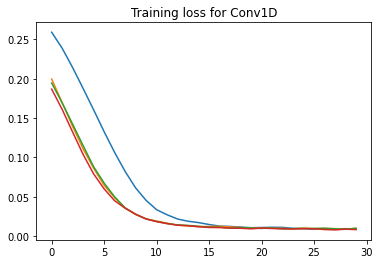

In [23]:
for i in range(NFOLD-1):
    loss = cnnv1D_result[i]['loss']
    plt.plot(loss)
    plt.title('Training loss for Conv1D')

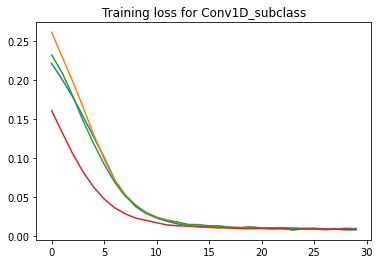

In [24]:
for i in range(NFOLD-1):
    loss = cnnv1D_subclass_result[i]['loss']
    plt.plot(loss)
    plt.title('Training loss for Conv1D_subclass')

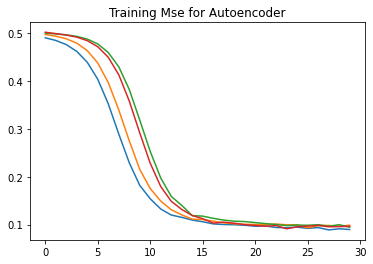

In [25]:
for i in range(NFOLD-1):
    mse = cnn1D_encoder_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Training Mse for Autoencoder')

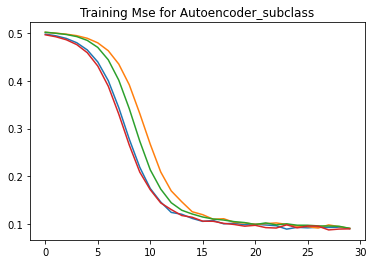

In [26]:
for i in range(NFOLD-1):
    mse = cnn1D_encoder_subclass_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Training Mse for Autoencoder_subclass')

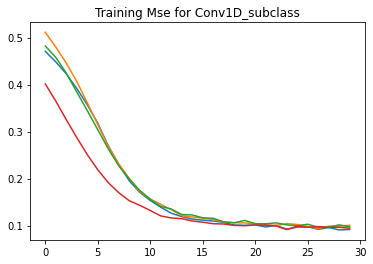

In [27]:
for i in range(NFOLD-1):
    mse = cnnv1D_subclass_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Training Mse for Conv1D_subclass')

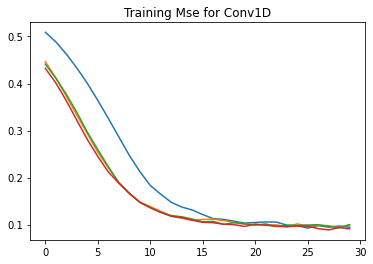

In [28]:
for i in range(NFOLD-1):
    mse = cnnv1D_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Training Mse for Conv1D')

26/26 [==============================] - 1s 2ms/step


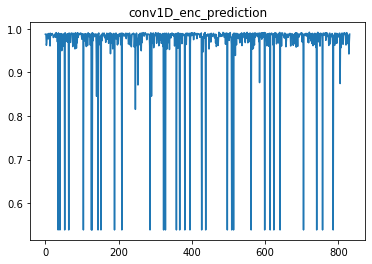

In [29]:
cnn1D_enc_predict = autoencoder.predict(test_dataset, verbose = True)
plt.title("conv1D_enc_prediction")
plt.plot(cnn1D_enc_predict)

(array([ 32.,   0.,   0.,   0.,   0.,   0.,   3.,   3.,   3., 791.]),
 array([0.5389862 , 0.58428055, 0.6295749 , 0.6748692 , 0.7201635 ,
        0.76545787, 0.8107522 , 0.85604656, 0.90134084, 0.9466352 ,
        0.99192953], dtype=float32),
 <BarContainer object of 10 artists>)

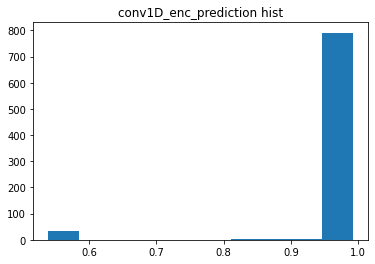

In [30]:
plt.title("conv1D_enc_prediction hist")
plt.hist(cnn1D_enc_predict)

26/26 [==============================] - 0s 2ms/step


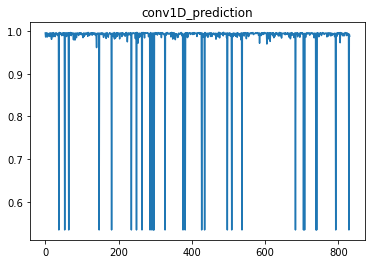

In [31]:
conv1D_predict = conv1D.predict(test_dataset, verbose = True)
plt.title("conv1D_prediction")
plt.plot(conv1D_predict)

(array([ 27.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 805.]),
 array([0.5338045 , 0.5801835 , 0.62656254, 0.6729415 , 0.71932054,
        0.76569957, 0.8120786 , 0.8584576 , 0.9048366 , 0.9512156 ,
        0.99759465], dtype=float32),
 <BarContainer object of 10 artists>)

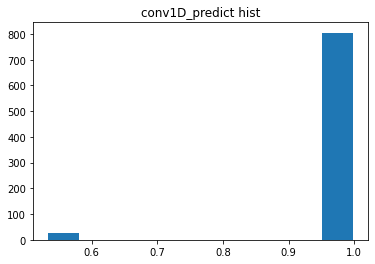

In [32]:
plt.title("conv1D_predict hist")
plt.hist(conv1D_predict)